The purpose of these experiments is to evaluate the predictive performance **(test accuracy)** of MF as a function of 

(i) fraction of training data and 

(ii) training time.

- We divide the training data into **100 mini-batches** and we compare the performance of online random forests (MF, ORF-Saffari [20]) to batch random forests (Breiman-RF, ERT-k, ERT-1) which are trained on the same fraction of the training data.
- We evaluate on four of the five datasets (usps, satimages, letter, dna) — we excluded the mushroom dataset as even very simple logical rules achieve > 99% accuracy on this dataset. 
- We re-scaled the datasets such that each feature takes on values in the range [0, 1] (by subtracting the min value along that dimension and dividing by the range along that dimension, where range = max − min).

As is common in the random forest literature [2], we set **the number of trees M = 100.**

- For Mondrian forests, we set the lifetime λ = ∞ and the HNSP discount parameter γ = 10D. 

- For Breiman-RF and ERT, the hyper parameters are set to default values. 

- We repeat each algorithm with five random initializations and report the mean performance.

# Experiments

Compare (both in time complexity & performance) the coded algorithm [on 2-3 real-world datasets] with classical random forests in the online mode, i.e. with forests that are

(1) completely refitted on data of steps [1, t] each step t

(2) Partially fitted for every new observation (some new trees fitted, some old removed)

(3) rolling-window refitting on [t-h, t]

In [1]:
from experiments import run_all_methods_all_datasets

%matplotlib inline
%load_ext autoreload
%autoreload 2

Loading usps...
X_train.shape:	 (7291, 256)
y_train.shape:	 (7291,)
X_test.shape:	 (2007, 256)
y_test.shape:	 (2007,)
Running on usps...
	classical_full_data
	classical_window_1
	classical_window_3
	classical_window_5
	classical_increment_frac_0.2
	classical_increment_frac_0.5
	extratrees_full_data
	extratrees_increment_frac_0.2
	extratrees_increment_frac_0.5
	mondrian_skgarden
	mondrian_our


IndexError: index 2 is out of bounds for axis 0 with size 2

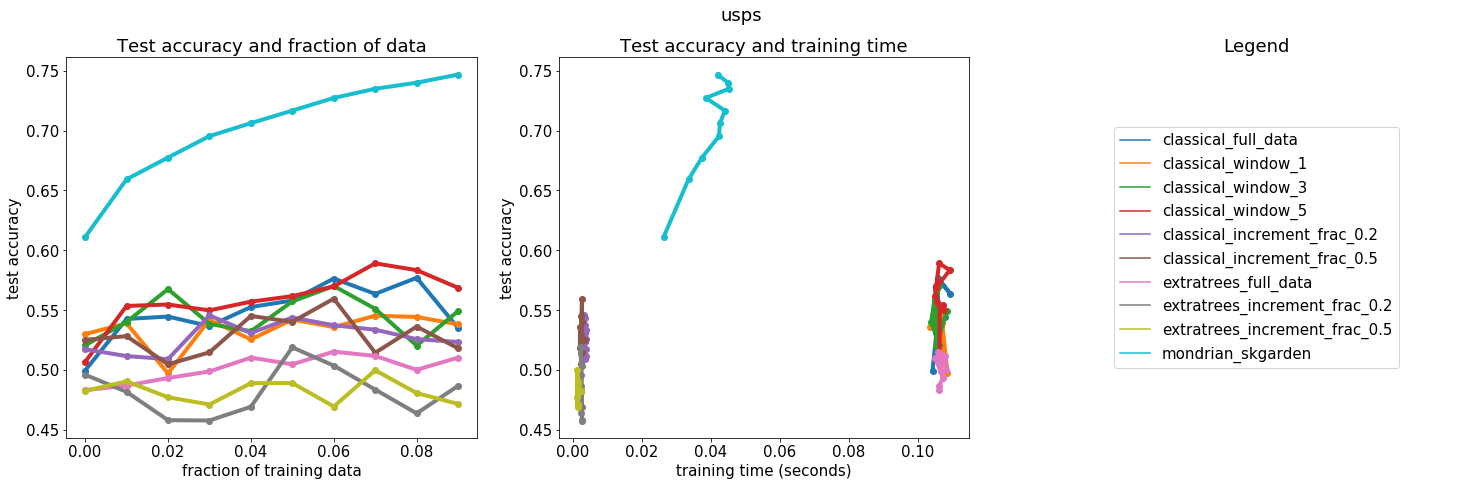

In [6]:
%%time

n_batches = 10
n_estimators = 2
max_depth = 3
n_iter = 5

run_all_methods_all_datasets(n_iter, n_batches, n_estimators, max_depth)